<a href="https://colab.research.google.com/github/indhu68/Intro_To_DL/blob/main/Homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
import seaborn as sns
from tqdm.notebook import tqdm
torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)
np.random.seed(123)

In [67]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [68]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
# Calculate mean and std
images = torch.stack([img_t for img_t, _ in train_dataset], dim=3)
mean = images.view(3, -1).mean(dim=1)
std = images.view(3, -1).std(dim=1)

Files already downloaded and verified


In [69]:
mean,std

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

In [70]:
cifar10 = datasets.CIFAR10(
    './data', train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [71]:
cifar10_val = datasets.CIFAR10(
     './data', train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [72]:
image1, label = cifar10[0]
print(image1.shape)

torch.Size([3, 32, 32])


In [73]:
train_loader = DataLoader(cifar10, batch_size=32, shuffle=True, num_workers=3)
test_loader = DataLoader(cifar10_val, batch_size=32, shuffle=False, num_workers=3)

In [74]:
def train_and_evaluate_model(model, criterion, optimizer, train_loader, test_loader, device='cuda', n_epochs = 20):
    def calculate_metrics(predictions, targets):
        accuracy = 100 * sum([p == t for p, t in zip(predictions, targets)]) / len(targets)
        precision = precision_score(targets, predictions, average='weighted')
        recall = recall_score(targets, predictions, average='weighted')
        f1 = f1_score(targets, predictions, average='weighted')
        return accuracy, precision, recall, f1

    model.to(device)

    train_loss_list, val_loss_list, val_accuracy_list = [], [], []

    # Training loop
    epochs = n_epochs
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss_list.append(running_loss / len(train_loader))

        # Validation loop
        running_loss = 0.0
        correct = 0
        total = 0
        model.eval()
        all_predictions, all_targets = [], []
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(test_loader, 0):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_predictions.extend(predicted.tolist())
                all_targets.extend(labels.tolist())

        val_loss_list.append(running_loss / len(test_loader))
        val_accuracy = 100 * correct / total
        val_accuracy_list.append(val_accuracy)

        print(f'Epoch {epoch + 1}, Training loss: {train_loss_list[-1]:.4f}, Validation loss: {val_loss_list[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


    model.eval()
    all_predictions, all_targets = [], []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader, 0):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.tolist())
            all_targets.extend(targets.tolist())

    accuracy, precision, recall, f1 = calculate_metrics(all_predictions, all_targets)

    # Print the metrics
    print(f'\nFinal Evaluation Metrics:')
    print(f'Accuracy: {accuracy:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Return metrics
    return {
        'train_loss': train_loss_list,
        'val_loss': val_loss_list,
        'val_accuracy': val_accuracy_list,
        'final_accuracy': accuracy,
        'final_precision': precision,
        'final_recall': recall,
        'final_f1': f1,
        'all_targets': all_targets,
        'all_predictions': all_predictions,
        'model': model
    }

In [75]:
class AlexNet(nn.Module):
    def __init__(self, dropout_p,num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=dropout_p),
            nn.Conv2d(48, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

        )



        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_p),
            nn.Linear(6272, 1024),  # Corrected to match the actual flattened size
            nn.ReLU(inplace=True),

            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [76]:
model = AlexNet(dropout_p=0)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [77]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0, inplace=False)
    (4): Conv2d(48, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0, inplace=False)
    (1): Linear(in_features=6272, out_features=1024, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [78]:
model_without_dropout = train_and_evaluate_model(model, criterion, optimizer, train_loader, test_loader, device, n_epochs=30)


Epoch 1, Training loss: 1.7436, Validation loss: 1.4333, Validation Accuracy: 48.67%
Epoch 2, Training loss: 1.2988, Validation loss: 1.2156, Validation Accuracy: 57.28%
Epoch 3, Training loss: 1.0798, Validation loss: 1.0079, Validation Accuracy: 65.14%
Epoch 4, Training loss: 0.9362, Validation loss: 0.9236, Validation Accuracy: 67.84%
Epoch 5, Training loss: 0.8257, Validation loss: 0.8584, Validation Accuracy: 70.16%
Epoch 6, Training loss: 0.7275, Validation loss: 0.8613, Validation Accuracy: 70.53%
Epoch 7, Training loss: 0.6375, Validation loss: 0.7791, Validation Accuracy: 73.66%
Epoch 8, Training loss: 0.5533, Validation loss: 0.7605, Validation Accuracy: 74.16%
Epoch 9, Training loss: 0.4678, Validation loss: 0.7132, Validation Accuracy: 76.05%
Epoch 10, Training loss: 0.3896, Validation loss: 0.7664, Validation Accuracy: 74.93%
Epoch 11, Training loss: 0.3110, Validation loss: 0.8069, Validation Accuracy: 75.55%
Epoch 12, Training loss: 0.2370, Validation loss: 0.8674, Valid

In [79]:
total_params = sum(p.numel() for p in model_without_dropout['model'].parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 7012554


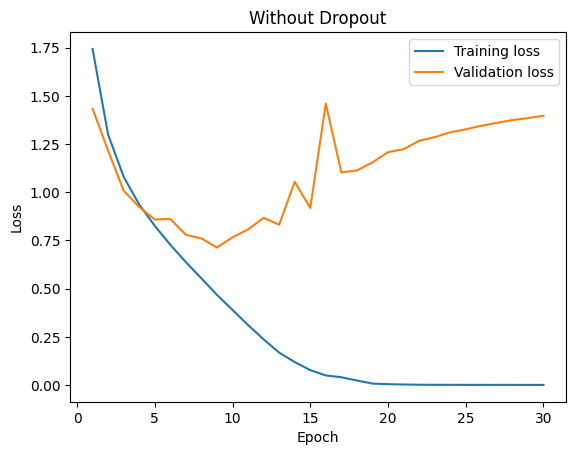

In [80]:
epochs_list = [i for i in range(1, 30+1, 1)]
plt.plot(epochs_list, model_without_dropout['train_loss'], label='Training loss')
plt.plot(epochs_list, model_without_dropout['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Without Dropout')
plt.legend()
plt.show()

In [81]:
model_with_dropout = AlexNet(dropout_p=0.5)
model_with_dropout = model_with_dropout.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_with_dropout.parameters(), lr=0.01)

In [82]:
print(model_with_dropout)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(48, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6272, out_features=1024, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [83]:
model_with_dropout_metrics = train_and_evaluate_model(model_with_dropout, criterion, optimizer, train_loader, test_loader, device, n_epochs=30)


Epoch 1, Training loss: 1.8247, Validation loss: 1.6226, Validation Accuracy: 41.02%
Epoch 2, Training loss: 1.4401, Validation loss: 1.3607, Validation Accuracy: 54.53%
Epoch 3, Training loss: 1.2781, Validation loss: 1.2632, Validation Accuracy: 57.73%
Epoch 4, Training loss: 1.1517, Validation loss: 1.1206, Validation Accuracy: 63.71%
Epoch 5, Training loss: 1.0628, Validation loss: 1.0601, Validation Accuracy: 66.34%
Epoch 6, Training loss: 0.9950, Validation loss: 0.9792, Validation Accuracy: 66.85%
Epoch 7, Training loss: 0.9328, Validation loss: 0.9083, Validation Accuracy: 70.42%
Epoch 8, Training loss: 0.8804, Validation loss: 0.8843, Validation Accuracy: 70.63%
Epoch 9, Training loss: 0.8348, Validation loss: 0.8308, Validation Accuracy: 71.88%
Epoch 10, Training loss: 0.7899, Validation loss: 0.7807, Validation Accuracy: 74.16%
Epoch 11, Training loss: 0.7512, Validation loss: 0.7432, Validation Accuracy: 75.54%
Epoch 12, Training loss: 0.7129, Validation loss: 0.7114, Valid

In [84]:
total_params = sum(p.numel() for p in model_with_dropout_metrics['model'].parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 7012554


In [85]:
total_params = sum(p.numel() for p in model_with_dropout_metrics['model'].parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 7012554


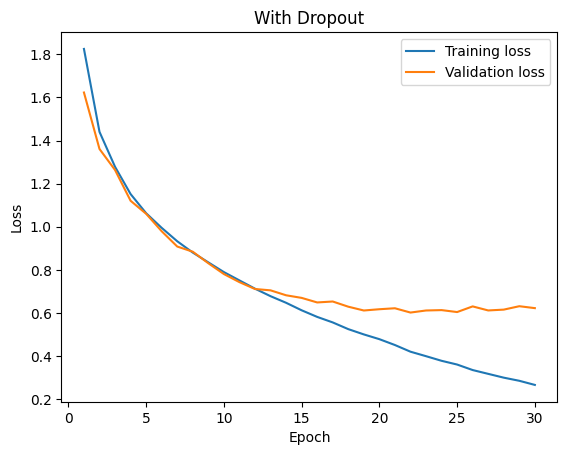

In [86]:
epochs_list = [i for i in range(1, 30+1, 1)]
plt.plot(epochs_list, model_with_dropout_metrics['train_loss'], label='Training loss')
plt.plot(epochs_list, model_with_dropout_metrics['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('With Dropout')
plt.legend()
plt.show()

In [87]:
import torch.nn.functional as F
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, dropout_rate=0.0):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity()

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(identity)
        out = F.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, block, num_blocks, dropout_rate, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2, dropout_rate=dropout_rate)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, dropout_rate=dropout_rate)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride, dropout_rate):
        layers = [block(self.in_channels, out_channels, stride, dropout_rate=dropout_rate)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels, dropout_rate=dropout_rate))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x


In [88]:
model_without_dropout = ResNet18(BasicBlock, [2, 2, 2, 2], 0, num_classes=10)  # 4 blocks with 2 layer each
model_without_dropout.to(device)
print(model_without_dropout)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Identity()
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, ep

In [89]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_without_dropout.parameters(), lr=0.01)

In [90]:
model_without_dropout_metrics = train_and_evaluate_model(model_without_dropout, criterion, optimizer, train_loader, test_loader, device, n_epochs=30)


Epoch 1, Training loss: 1.2766, Validation loss: 0.9667, Validation Accuracy: 65.46%
Epoch 2, Training loss: 0.7734, Validation loss: 0.7784, Validation Accuracy: 73.57%
Epoch 3, Training loss: 0.5466, Validation loss: 0.7834, Validation Accuracy: 73.98%
Epoch 4, Training loss: 0.3786, Validation loss: 0.6750, Validation Accuracy: 77.29%
Epoch 5, Training loss: 0.2543, Validation loss: 0.8791, Validation Accuracy: 74.13%
Epoch 6, Training loss: 0.1603, Validation loss: 0.8317, Validation Accuracy: 77.36%
Epoch 7, Training loss: 0.1049, Validation loss: 1.0105, Validation Accuracy: 76.52%
Epoch 8, Training loss: 0.0700, Validation loss: 0.9616, Validation Accuracy: 77.96%
Epoch 9, Training loss: 0.0465, Validation loss: 0.7886, Validation Accuracy: 80.81%
Epoch 10, Training loss: 0.0362, Validation loss: 0.7825, Validation Accuracy: 81.35%
Epoch 11, Training loss: 0.0290, Validation loss: 0.7669, Validation Accuracy: 82.13%
Epoch 12, Training loss: 0.0258, Validation loss: 1.1374, Valid

In [91]:
total_params = sum(p.numel() for p in model_without_dropout_metrics['model'].parameters())
print(f'Total number of parameters in the model: {total_params}')


Total number of parameters in the model: 11173962


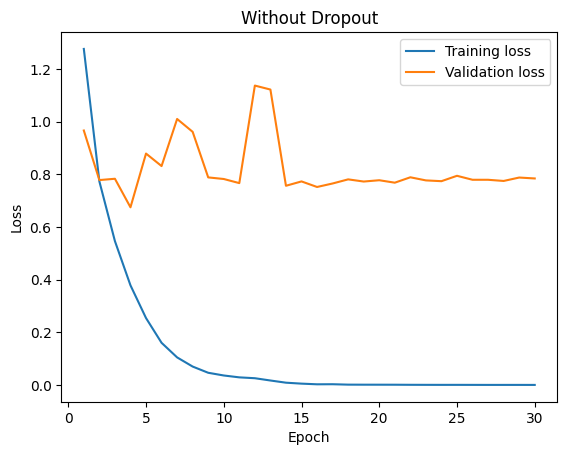

In [93]:
epochs_list = [i for i in range(1, 30+1, 1)]
plt.plot(epochs_list, model_without_dropout_metrics['train_loss'], label='Training loss')
plt.plot(epochs_list, model_without_dropout_metrics['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Without Dropout')
plt.legend()
plt.show()

In [96]:
model_with_dropout = ResNet18(BasicBlock, [2, 2, 2, 2], 0.5, num_classes=10)  # 4 blocks with 2 layer each
model_with_dropout.to(device)
print(model_with_dropout)



ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.5, inplace=False)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2):

In [97]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_with_dropout.parameters(), lr=0.01)

In [98]:
model_with_dropout_metrics = train_and_evaluate_model(model_with_dropout, criterion, optimizer, train_loader, test_loader, device, n_epochs=30)


Epoch 1, Training loss: 1.6429, Validation loss: 1.6399, Validation Accuracy: 43.34%
Epoch 2, Training loss: 1.2525, Validation loss: 1.2092, Validation Accuracy: 58.34%
Epoch 3, Training loss: 1.0420, Validation loss: 0.9238, Validation Accuracy: 67.11%
Epoch 4, Training loss: 0.9139, Validation loss: 0.8945, Validation Accuracy: 68.85%
Epoch 5, Training loss: 0.8250, Validation loss: 0.8346, Validation Accuracy: 71.28%
Epoch 6, Training loss: 0.7442, Validation loss: 0.7542, Validation Accuracy: 74.35%
Epoch 7, Training loss: 0.6818, Validation loss: 0.6578, Validation Accuracy: 77.13%
Epoch 8, Training loss: 0.6244, Validation loss: 0.7127, Validation Accuracy: 76.22%
Epoch 9, Training loss: 0.5802, Validation loss: 0.5948, Validation Accuracy: 79.97%
Epoch 10, Training loss: 0.5417, Validation loss: 0.5922, Validation Accuracy: 80.45%
Epoch 11, Training loss: 0.5050, Validation loss: 0.5804, Validation Accuracy: 81.01%
Epoch 12, Training loss: 0.4782, Validation loss: 0.5146, Valid

In [99]:
total_params = sum(p.numel() for p in model_with_dropout_metrics['model'].parameters())
print(f'Total number of parameters in the model: {total_params}')

Total number of parameters in the model: 11173962


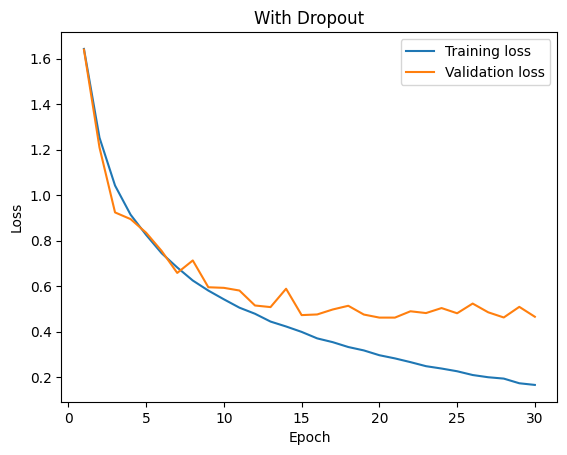

In [101]:
epochs_list = [i for i in range(1, 30+1, 1)]
plt.plot(epochs_list, model_with_dropout_metrics['train_loss'], label='Training loss')
plt.plot(epochs_list, model_with_dropout_metrics['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('With Dropout')
plt.legend()
plt.show()